In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 
import metpy
import cartopy.crs as ccrs
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points

# 2021.10.17 尝试插值到准均匀网格

-   将经纬度网格上的数据处理到准均匀的投影上的网格

# 2021.11.09

-   单独计算出U,V之后进行网格转换

## 数据读入

In [14]:
allwinds = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/allwinds_daily/"
# ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ds_ke_sum = xr.open_dataset(dir_out + "allwinds_vi_8.5-11.5km.nc")
allwinds['rcm'] = ds_ke_sum

dir_out = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/allwinds_daily/"
# ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ds_ke_sum = xr.open_dataset(dir_out + "allwinds_vi_8.5-11.5km.nc")
allwinds['era5i'] = ds_ke_sum

# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
var_rmnan = allwinds
# var_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
# var_rmnan['era5i'] = ke_sum['era5i'] #.interpolate_na(dim = 'lon', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [15]:
# 修改ERA5I coords
var_rmnan['era5i'] = var_rmnan['era5i'].rename({"time":"Time", "lon":"longitude", "lat":"latitude"})
# var_rmnan['era5i']._coords = var_rmnan['rcm']._coords
right_era5i_time = var_rmnan['rcm'].Time.loc[var_rmnan['rcm'].Time.dt.month.isin([4,5,6,7,8])]
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"Time":right_era5i_time})
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"latitude":var_rmnan['rcm'].latitude})
var_rmnan['era5i'] = var_rmnan['era5i'].assign_coords({"longitude":var_rmnan['rcm'].longitude})

In [19]:
# 选取数据范围
sel_dict = {}
month_sel = [4,5,6,7,8]
# month_sel_vr  = var_rmnan['vr'].Time.dt.month.isin(month_sel)
month_sel_rcm = var_rmnan['rcm'].Time.dt.month.isin(month_sel)
month_sel_era5i = var_rmnan['era5i'].Time.dt.month.isin(month_sel)


# lat_s = 15.
lat_s = 10.
lat_e = 55.
lon_s = 70.
# lon_s = 75.
# lon_s = 80.
lon_e = 140.
# lon_e = 135.
lat = var_rmnan['rcm'].latitude
lon = var_rmnan['rcm'].longitude
sel_dict['latitude'] = lat[(lat>=lat_s) & (lat<=lat_e)]
sel_dict['longitude'] = lon[(lon>=lon_s) & (lon<=lon_e)]
# sel_dict['latitude'] = lat#[(lat>=20) & (lat<=50)]
# sel_dict['longitude'] = lon#[(lon>=100) & (lon<=140)]

var_sel = {}
# sel_dict['Time'] = month_sel_vr
var_sel['rcm']  = var_rmnan['rcm'].loc[sel_dict]
# sel_dict['Time'] = month_sel_rcm
# var_sel['rcm'] = var_rmnan['rcm'].loc[sel_dict]
# sel_dict['Time'] = month_sel_era5i
var_sel['era5i'] = var_rmnan['era5i'].loc[sel_dict]



# # 添加区域对角线长度
# import haversine as hs
# loc1=(lat_s,lon_s)
# loc2=(lat_e,lon_e)
# diagonal_length = hs.haversine(loc1,loc2)
# print("对角线长度为： " + str(diagonal_length) + " km")
# # diagonal_length = 7935. # km largescale
# # diagonal_length = 4840. # km smallscale


## 插值尝试

每一个part分开运行，以免出现变量名的混淆

### 在新的坐标系下使用scipy进行插值的尝试 （完成）

- 尝试使用自己定义的scipy的插值方法完成2d网格的插值，只是需要先自己定义出来需求的网格，先进行此步骤，后续绘图检查区域

In [30]:
from scipy.interpolate import griddata
data_origin = var_sel['era5i']['uwnd'][:,0,:,:]
# to_proj = ccrs.AlbersEqualArea(central_longitude=100., central_latitude=32.5) # 进行插值的坐标系
to_proj = ccrs.LambertConformal(central_longitude=110., central_latitude=35) # 进行插值的坐标系
latlon_proj = ccrs.Geodetic() # 最后得到上面投影的经纬度坐标
# 提取regular经纬度网格数据
lon = data_origin.longitude
lat = data_origin.latitude
Time = data_origin.Time
# 制作经纬度网格数据的投影坐标系下的 x y 坐标
latv, lonv = np.meshgrid(lat.values, lon.values, indexing = 'ij') # 合并2D lat & lon
out = to_proj.transform_points(ccrs.Geodetic(), lonv, latv)       # 得到插值坐标系的 x y轴
proj_x = out[:,:,0]
proj_y = out[:,:,1]
# 生成网格的函数 先制作单层的数据
def create_interp_mesh(newproj_x_start = -200*1e4, newproj_x_end   = 200*1e4, newproj_y_start = -200*1e4, newproj_y_end   = 200*1e4, resolution = 1*1e4):
    '给出x y在笛卡尔坐标系下的起始点，结束点，分辨率（单位：m），生成2D的笛卡尔坐标系x，y网格'
    x_step = int((newproj_x_end - newproj_x_start) / resolution) + 1
    y_step = int((newproj_y_end - newproj_y_start) / resolution) + 1
    newproj_x,newproj_y = np.meshgrid(np.linspace(newproj_x_start, newproj_x_end, x_step), np.linspace(newproj_y_start, newproj_y_end, y_step), indexing = 'xy')
    print("create mesh!")
    return [newproj_x, newproj_y]    

[newproj_x, newproj_y] = create_interp_mesh()
# 使用scipy进行插值处理
interp_2d = griddata( (proj_x.reshape(-1), proj_y.reshape(-1)), data_origin[0,:,:].values.reshape(-1), xi = (newproj_x, newproj_y), method='linear')
# 插值后网格的经纬度坐标
newgrid = latlon_proj.transform_points(to_proj, newproj_x, newproj_y)    # 得到插值坐标系的经纬度坐标，用于绘图
newlon = newgrid[:,:,0]
newlat = newgrid[:,:,1]

create mesh!


- 使用单线程，每个时次进行插值,耗时较久

In [ ]:
# # 每个时次的2D图进行一次插值
# data_origin = var_sel['rcm']
# # timesize = Time.size
# timesize = 30
# interp_3d_oldloop = np.empty(shape = (timesize, interp_2d.shape[0], interp_2d.shape[1]))   
# for itime in range(0, timesize):
#     interp_3d_oldloop[itime,:,:] = griddata( (proj_x.reshape(-1), proj_y.reshape(-1)), data_origin[itime,:,:].values.reshape(-1), xi = (newproj_x, newproj_y), method='linear')

- 使用多线程插值，暴力计算
- 补充了写出nc文件的部分，注意每个模拟单独写出，切换最开始的 imod

In [46]:
from multiprocessing import Pool
import os, time, random
# 进行单个时间步插值的函数
for imod in ['rcm','era5i']:
    varname = 'uwnd'
    data_origin = var_sel[imod][varname][:,0,:,:]
    timesize = data_origin.Time.size
    # timesize = 100
    interp_3d = np.zeros(shape = (timesize, interp_2d.shape[0], interp_2d.shape[1]))   
    def interp_griddata_2d(proj_x, proj_y, data_origin_2d, newproj_x, newproj_y, return_interp_2d):
        '用于二维插值，在时间维上并发进行的部分'
        return_interp_2d = griddata( (proj_x.reshape(-1), proj_y.reshape(-1)), data_origin_2d.reshape(-1), xi = (newproj_x, newproj_y), method='linear')
        return return_interp_2d
    print('Parent process %s.' % os.getpid())
    p = Pool(40) # Poll 5 for 5s 
    p_list = [] # 放置所有进程，以免被阻塞

    for itime in range(0, timesize):
        p_list.append( p.apply_async(interp_griddata_2d, args = ( proj_x, proj_y, data_origin[itime,:,:].values, newproj_x, newproj_y, interp_3d[itime, :, :]) ) )
        # p.apply_async(interp_griddata_2d, args = ( proj_x, proj_y, data_origin[itime,:,:].values, newproj_x, newproj_y, interp_3d[itime, :, :]) )

    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')

    # 将所有进程的结果输出
    for itime in range(0, timesize):
        interp_3d[itime,:,:] = p_list[itime].get()

    # 写入到文件
    write_into_file = True
    out_path = {} # 写入路径
    out_filename = "allwinds_8.5-11.5_km_vi_LambertConformal.nc"
    out_path['rcm'] = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/allwinds_daily/" + out_filename # RCM
    out_path['era5i'] = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/allwinds_daily/" + out_filename # ERA5I

    if (write_into_file):
        # os.system('rm -rf ' + out_path[imod])
        lat_attrs_dict = {'standard_name': 'latitude','long_name': 'latitude','units': 'degree_north','axis': 'XY'}
        newlat_xr = xr.DataArray(newlat, name="XLAT", dims = ("south_to_north", "west_to_east"), attrs = lat_attrs_dict )
        lon_attrs_dict = {'standard_name': 'longitude','long_name': 'longitude','units': 'degree_east','axis': 'XY'}
        newlon_xr = xr.DataArray(newlon, name="XLONG", dims = ("south_to_north", "west_to_east"), attrs = lon_attrs_dict)
        interp_3d_xr = xr.DataArray(interp_3d, name=varname, dims = ("Time","south_to_north","west_to_east"))
        add_coords_dict = {"XLAT":(("south_to_north", "west_to_east"),newlat_xr,lat_attrs_dict), \
        "XLONG":(("south_to_north", "west_to_east"),newlon_xr,lat_attrs_dict), \
        "Time":("Time", Time)} # 居然 attrs 是直接加在最后面？
        to_ncfile = interp_3d_xr.assign_coords(add_coords_dict)
        to_ncfile.to_netcdf(out_path[imod])

Parent process 304744.
Waiting for all subprocesses done...
All subprocesses done.
Parent process 304744.
Waiting for all subprocesses done...
All subprocesses done.


## 绘图检查

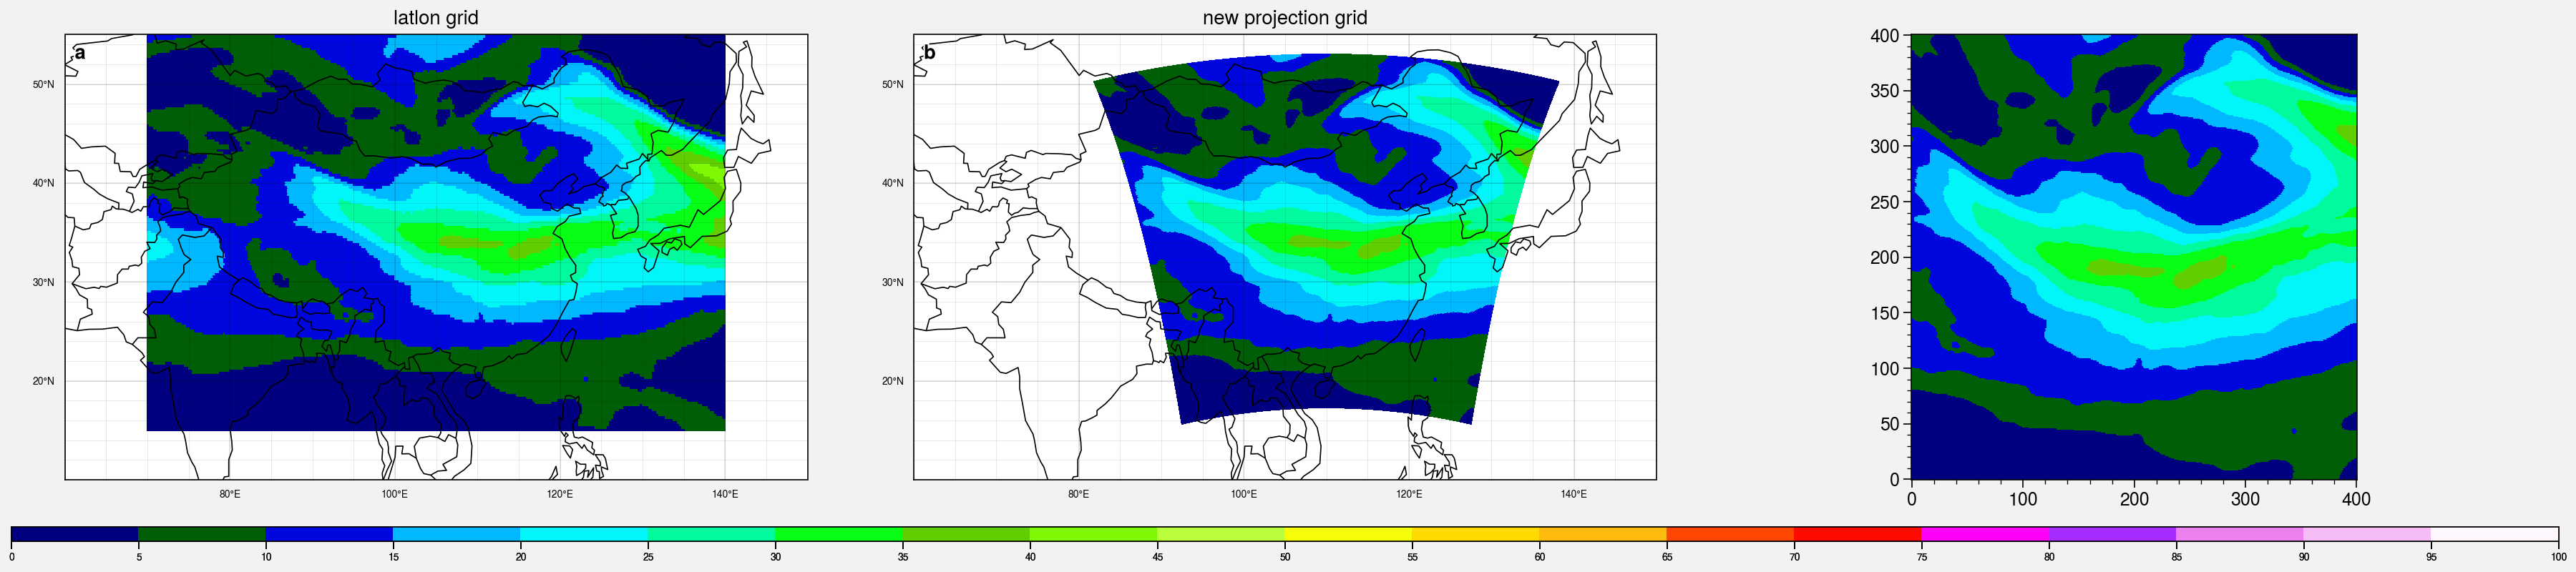

In [31]:
from matplotlib import pyplot as plt
import proplot as plot
fig, axs = plot.subplots(ncols=3, nrows=1, proj=(('cyl'),('cyl')), figsize=(18,4))
# plt.contourf(img)
# plt.colorbar()
cmap = "gist_ncar"
ticks = plot.arange(0, 100, 5)
compare_time_step = 0
# grids
m = axs[0].pcolormesh(lon, lat, data_origin[compare_time_step,:,:].values, levels=ticks, cmap=cmap)
m = axs[1].pcolormesh(newlon, newlat, interp_2d[:,:], levels=ticks, cmap=cmap)
m = axs[2].pcolormesh(interp_2d[:,:], levels=ticks, cmap=cmap)
axs[0].set_aspect(1.2, 'box')
axs[1].set_aspect(1.2, 'box')
axs[2].set_aspect(1., 'box')
# points
# m = axs[0].pcolormesh(lon, lat, data_origin[compare_time_step,:,:].values, levels=ticks, cmap=cmap)
# m = axs[1].pcolormesh(newlon, newlat, interp_3d[compare_time_step,:,:], levels=ticks, cmap=cmap)
# m = axs[2].pcolormesh(interp_3d[compare_time_step,:,:], levels=ticks, cmap=cmap)
axs[0].format(title = "latlon grid")
axs[1].format(title = "new projection grid")
axs[0:2].format(
abc=True,
abcloc = 'ul',
#-----GEO axis-----
borders = True,
coast = True,
lonlim=(60, 150), latlim=(10, 55),
labels = True,
gridlabelsize = 5,
gridminor = True,
longrid  = True,
latgrid  = True,

)
colorbar = fig.colorbar(m, loc='b', cmap=cmap, width=0.1, ticklabelsize=5,ticks=ticks)

## 输出到临时文件
-   手动测试文件写出部分
-   需要赋值XLAT XLONG到输出的变量上，用于新坐标的绘制


In [ ]:
lat_attrs_dict = {'standard_name': 'latitude','long_name': 'latitude','units': 'degree_north','axis': 'XY'}
newlat_xr = xr.DataArray(newlat, name="XLAT", dims = ("south_to_north", "west_to_east"), attrs = lat_attrs_dict )

lon_attrs_dict = {'standard_name': 'longitude','long_name': 'longitude','units': 'degree_east','axis': 'XY'}
newlon_xr = xr.DataArray(newlon, name="XLONG", dims = ("south_to_north", "west_to_east"), attrs = lon_attrs_dict)

interp_3d_xr = xr.DataArray(interp_3d, name="ke", dims = ("Time","south_to_north","west_to_east"))
add_coords_dict = {"XLAT":(("south_to_north", "west_to_east"),newlat_xr,lat_attrs_dict), \
"XLONG":(("south_to_north", "west_to_east"),newlon_xr,lat_attrs_dict), \
"Time":("Time", Time)} # 居然 attrs 是直接加在最后面？

to_ncfile = interp_3d_xr.assign_coords(add_coords_dict)

In [ ]:
# out_path = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi_proj/ke_all_8.5-11.5_km_vi_LambertConformal.nc" # VR
# out_path = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi_proj/ke_all_8.5-11.5_km_vi_LambertConformal.nc" # RCM
out_path = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/ke_daily_vi_proj/ke_all_8.5-11.5_km_vi_LambertConformal_case1.nc" # ERA5I
os.system('rm -rf ' + out_path)
to_ncfile.to_netcdf(out_path)